<a href="https://colab.research.google.com/github/MaiXuanNhat/BrainStrokeRandomForest/blob/main/BrainStrokeRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.   Import Data**

In [275]:
## imports ##
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.datasets import load_wine,load_boston
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,mean_absolute_error,mean_squared_error,r2_score,make_scorer
from abc import ABC,abstractmethod
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [278]:
all_data = pd.read_csv('brain_stroke.csv')
all_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


# **2.   Data Analysis**

In [279]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [280]:
all_data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [281]:
#normalize data
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
columns = ['gender', 'ever_married', 'work_type', 'Residence_type','smoking_status']
all_col_mappings={}
for col in columns:
    all_data[col] = label_encoder.fit_transform(all_data[col])
    col_mappings  = {index: label for index, label in enumerate(label_encoder.classes_)}
    print(col_mappings)
    col_mappings = {v: k for k, v in col_mappings.items()}
    all_col_mappings.update(col_mappings)

{0: 'Female', 1: 'Male'}
{0: 'No', 1: 'Yes'}
{0: 'Govt_job', 1: 'Private', 2: 'Self-employed', 3: 'children'}
{0: 'Rural', 1: 'Urban'}
{0: 'Unknown', 1: 'formerly smoked', 2: 'never smoked', 3: 'smokes'}


In [282]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   int64  
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   int64  
 5   work_type          4981 non-null   int64  
 6   Residence_type     4981 non-null   int64  
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   int64  
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 428.2 KB


In [283]:
target = 'stroke'
X = all_data.loc[:,all_data.columns!=target]
y = all_data.loc[:,all_data.columns==target]
print('Dimensions of X: ',X.shape)
print('Dimensions of y: ',y.shape)

Dimensions of X:  (4981, 10)
Dimensions of y:  (4981, 1)


0    4733
1     248
Name: stroke, dtype: int64


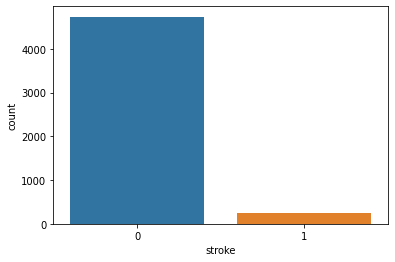

In [284]:
ax = sn.countplot(x=target,data=all_data)
print(all_data[target].value_counts())

In [285]:
percentage_no_stroke = 100*(4733/float(all_data.shape[0]))
percentage_yes_stroke = 100*(248/float(all_data.shape[0]))
print('percentage of people without stroke: %.2f%%' % percentage_no_stroke)
print('percentage of people having stroke: %.2f%%' % percentage_yes_stroke)

percentage of people without stroke: 95.02%
percentage of people having stroke: 4.98%


In [286]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

1    4733
0    4733
Name: stroke, dtype: int64


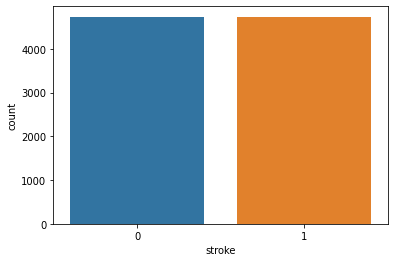

In [287]:
ax = sn.countplot(x=target,data=y)
print(y[target].value_counts())

In [288]:
y = y.squeeze()

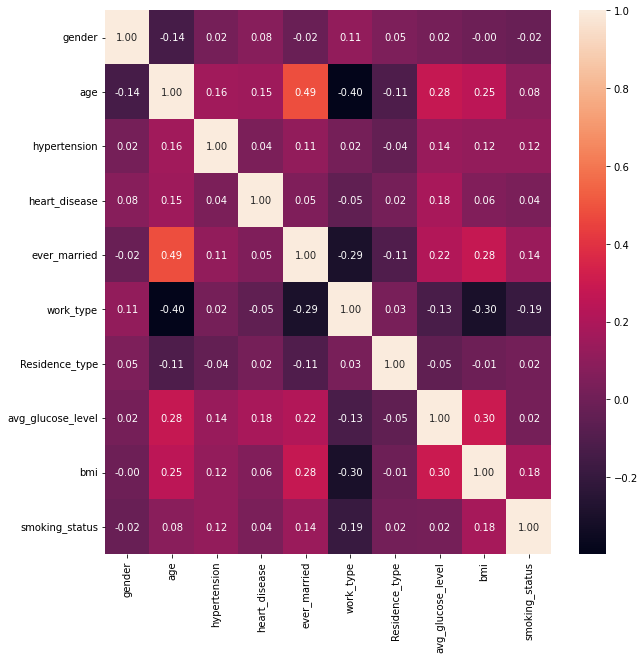

In [289]:
## plot the pearson correlation for our input features ##
fig, ax = plt.subplots(figsize = (10, 10)) 
dfCorr  = X.corr() 
sn.heatmap(dfCorr,annot=True, fmt=".2f") 
plt.show()

# **3.   Build RandomForestClassifier Model**

In [276]:
#base class for the random forest algorithm
class RandomForest(ABC):
    #initializer
    def __init__(self,n_trees=100):
        self.n_trees = n_trees
        self.trees   = []
    #private function to make bootstrap samples
    def __make_bootstraps(self,data):
        #initialize output dictionary & unique value count
        dc   = {}
        unip = 0
        #get sample size
        b_size = data.shape[0]
        #get list of row indexes
        idx = [i for i in range(b_size)]
        #loop through the required number of bootstraps
        for b in range(self.n_trees):
            #obtain boostrap samples with replacement
            sidx   = np.random.choice(idx,replace=True,size=b_size)
            b_samp = data[sidx,:]
            #compute number of unique values contained in the bootstrap sample
            unip  += len(set(sidx))
            #obtain out-of-bag samples for the current b
            oidx   = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx,:]
            #store results
            dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
        #return the bootstrap results
        return(dc)
    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees}

    #protected function to obtain the right decision tree
    @abstractmethod
    def _make_tree_model(self):
        pass
    #protected function to train the ensemble
    def _train(self,X_train,y_train):
        #package the input data
        training_data = np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
        #make bootstrap samples
        dcBoot = self.__make_bootstraps(training_data)
        #iterate through each bootstrap sample & fit a model ##
        tree_m = self._make_tree_model()
        dcOob    = {}
        for b in dcBoot:
            #make a clone of the model
            model = clone(tree_m)
            #fit a decision tree model to the current sample
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1, 1))
            #append the fitted model
            self.trees.append(model)
            #store the out-of-bag test set for the current bootstrap
            if dcBoot[b]['test'].size:
                dcOob[b] = dcBoot[b]['test']
            else:
                dcOob[b] = np.array([])
        #return the oob data set
        return(dcOob)
    #protected function to predict from the ensemble
    def _predict(self,X):
        #check we've fit the ensemble
        if not self.trees:
            print('You must train the ensemble before making predictions!')
            return(None)
        #loop through each fitted model
        predictions = []
        for m in self.trees:
            #make predictions on the input X
            yp = m.predict(X)
            #append predictions to storage list
            predictions.append(yp.reshape(-1,1))
        #compute the ensemble prediction
        ypred = np.mean(np.concatenate(predictions,axis=1),axis=1)
        #return the prediction
        return(ypred)

In [277]:
#class for random forest classifier
class RandomForestClassifier(RandomForest):
    #initializer
    def __init__(self,n_trees=100,max_depth=None,min_samples_split=2,criterion='entropy',class_weight=None):
        super().__init__(n_trees)
        self.max_depth             = max_depth
        self.min_samples_split     = min_samples_split
        self.criterion             = criterion
        self.class_weight          = class_weight
    #protected function to obtain the right decision tree
    def _make_tree_model(self):
        return(DecisionTreeClassifier(max_depth             = self.max_depth,
                                      min_samples_split     = self.min_samples_split,
                                      criterion             = self.criterion,
                                      class_weight          = self.class_weight))
    
    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees,
                'max_depth':self.max_depth,
                'min_samples_split':self.min_samples_split,
                'criterion':self.criterion,
                'class_weight':self.class_weight}
    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #call the protected training method
        dcOob = self._train(X_train,y_train)
        #if selected, compute the standard errors and print them
        if print_metrics:
            #initialise metric arrays
            accs = np.array([])
            pres = np.array([])
            recs = np.array([])
            f1ss = np.array([])
            #loop through each bootstrap sample
            for b,m in zip(dcOob,self.trees):
                #compute the predictions on the out-of-bag test set & compute metrics
                if dcOob[b].size:
                    yp  = m.predict(dcOob[b][:,:-1])
                    acc = accuracy_score(dcOob[b][:,-1],yp)
                    pre = precision_score(dcOob[b][:,-1],yp,average='weighted')   
                    rec = recall_score(dcOob[b][:,-1],yp,average='weighted')
                    f1s = f1_score(dcOob[b][:,-1],yp,average='weighted')
                    #store the error metrics
                    accs = np.concatenate((accs,acc.flatten()))
                    pres = np.concatenate((pres,pre.flatten()))
                    recs = np.concatenate((recs,rec.flatten()))
                    f1ss = np.concatenate((f1ss,f1s.flatten()))
            #print standard errors
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))
            print("Standard error in f1_score: %.2f" % np.std(f1ss))
    #predict from the ensemble
    def predict(self,X):
        #call the protected prediction method
        ypred = self._predict(X)
        #convert the results into integer values & return
        return(np.round(ypred).astype(int))

In [290]:
#convert all correlations to positive values
dfCorr = dfCorr.abs()

#loop through rows
for index, sRow in dfCorr.iterrows():
    #get the valid entries
    sCorrs = sRow[sRow.index != index]
    sCorrs = sCorrs[sCorrs > 0.8]
    #print out results
    if not sCorrs.empty:
        print('highly correlated input features: ',index,' & ',sCorrs.index.values)

In [291]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, shuffle=True)

In [292]:
#create a random forest with balance class weights enabled
rfc = RandomForestClassifier(class_weight="balanced")

## train the ensemble & view estimates for prediction error ##
rfc.fit(X_train.values,y_train.values,print_metrics=True)

Standard error in accuracy: 0.01
Standard error in precision: 0.01
Standard error in recall: 0.01
Standard error in f1_score: 0.01


In [293]:
# Predicting the Test set results
y_pred = rfc.predict(X_test)

# Making the Confusion Matrix
rfc_ac = accuracy_score(y_test, y_pred)
rfc_pr = precision_score(y_test, y_pred)
rfc_rc = recall_score(y_test, y_pred)
rfc_f1 = f1_score(y_test, y_pred)
print("RandomForest Accuracy: %.2f" % rfc_ac)
print("RandomForest Precision: %.2f" % rfc_pr)
print("RandomForest Recall: %.2f" % rfc_rc)
print("RandomForest F1 Score: %.2f" % rfc_f1)

RandomForest Accuracy: 0.94
RandomForest Precision: 0.92
RandomForest Recall: 0.96
RandomForest F1 Score: 0.94


# **4.   Use KNNClassifier to compare with RandomForestClassifier**

In [294]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_KNN = sc.fit_transform(X_train)
X_test_KNN = sc.transform(X_test)

# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
KNNClassifier = KNeighborsClassifier(n_neighbors = 5, p = 2)
KNNClassifier.fit(X_train_KNN, y_train)

# Predicting the Test set results
y_pred = KNNClassifier.predict(X_test_KNN)

# Making the Confusion Matrix
knn_ac = accuracy_score(y_test, y_pred)
knn_pr = precision_score(y_test, y_pred)
knn_rc = recall_score(y_test, y_pred)
knn_f1 = f1_score(y_test, y_pred)
print("KNN Accuracy: %.2f" % knn_ac)
print("KNN Precision: %.2f" % knn_pr)
print("KNN Recall: %.2f" % knn_rc)
print("KNN F1 Score: %.2f" % knn_f1)

KNN Accuracy: 0.87
KNN Precision: 0.81
KNN Recall: 0.95
KNN F1 Score: 0.88


# **5.   Apply the model to real data**

In [309]:
def stroke_predict(real_data):
  X_real = pd.DataFrame(real_data, columns = ['gender','age','hypertension','heart_disease','ever_married',
                                              'work_type','Residence_type','avg_glucose_level','bmi','smoking_status'])
  for col in columns:
      X_real[col] = X_real[col].map(all_col_mappings)
  y_pred = rfc.predict(X_real)
  if y_pred[0] == 0: print("no risk of stroke with a %.2f%% prediction accuracy" % (100*rfc_f1))
  else: print("have a stroke risk with a %.2f%% prediction accuracy" % (100*rfc_f1))

In [310]:
real_data = np.array([['Female',80.0,1,0,'Yes','Private','Urban',83.75,29.1,'never smoked']])
stroke_predict(real_data)

no risk of stroke with a 94.16% prediction accuracy
